# Forecasting sensors data using AI
Training model here to export the model and use it on the web we made. <br>
<br>
Note: Make sure to run the code from top to bottom without skipping any to avoid any errors.<br>
> PS. : It took me a lot of stress. Just to realize it really able to use one model for multiple output.



In [ ]:
# Import necessary libraries
import  numpy  as  np
import pandas  as  pd
import lightgbm as lgb
from sklearn.model_selection  import train_test_split
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
from sklearn.multioutput import MultiOutputRegressor
import pickle
import matplotlib.pyplot as plt

In [ ]:
Ds = pd.read_csv("sensor_data (2).csv")
sensors_dataset = ["Humidity", "Temperature", "Soil Moisture", "MQ135 Value"]
# convert timestamp to minute multiples of 15 [Credit to our mentor, aka Kak Mukhlas! :D]
Ds['Timestamp'] = pd.to_datetime(Ds['Timestamp']).dt.round('15min')
Ds = Ds.groupby('Timestamp').agg({ # find the mean value if there's some datas with same minute
    'Temperature': 'mean',
    'Humidity': 'mean',
    'Soil Moisture': 'mean',
    'MQ135 Value': 'mean',
}).reset_index()
Ds['hour'] = Ds['Timestamp'].dt.hour
Ds.dropna(inplace=True)

x = Ds[["hour", "Humidity", "Temperature", "Soil Moisture", "MQ135 Value"]]
y = Ds[sensors_dataset].shift(-1) # shift data for the target
y.dropna(inplace=True)
x = x.iloc[:-1] # target data have NaN values so x had to be adjusted
print(Ds) # making sure both feature and target data have same rows

             Timestamp   Humidity  Temperature  Soil Moisture  MQ135 Value  \
0  2024-07-21 10:15:00  59.914728    30.874745           2135         1004   
1  2024-07-21 10:30:00  58.967942    30.842337           2294         1025   
2  2024-07-21 10:45:00  59.483566    30.815879           1315         1024   
3  2024-07-21 11:00:00  59.852966    30.820194           2285         1002   
4  2024-07-21 11:15:00  58.719779    30.884078           1516         1044   
..                 ...        ...          ...            ...          ...   
90 2024-07-22 08:15:00  58.520026    30.888096           1944         1021   
91 2024-07-22 08:30:00  59.289928    30.893389           2375         1006   
92 2024-07-22 08:45:00  59.428846    30.881483           2429         1017   
93 2024-07-22 09:00:00  59.641038    30.814401           2461         1040   
94 2024-07-22 09:15:00  59.628809    30.854723           2145         1035   

    hour  
0     10  
1     10  
2     10  
3     11  
4     11

In [ ]:
xt, xs, yt, ys = train_test_split(x, y, test_size=0.3, shuffle=False) # perpare data for training and testing
# Training model using LightGBM
lgb_model = lgb.LGBMRegressor(learning_rate=0.05, n_estimators=100)
model = MultiOutputRegressor(lgb_model) # since we used 5 sensors in one model, it gonna have multioutput
model.fit(xt, yt)

y_pred = model.predict(xs) #check model prediction before exporting

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000387 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 102
[LightGBM] [Info] Number of data points in the train set: 65, number of used features: 5
[LightGBM] [Info] Start training from score 59.261544
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain

In [ ]:
# check MAE and with percentage
print("MAE: ")
for i in range(len(sensors_dataset)):
  print(f"{sensors_dataset[x]}: ", mean_absolute_error(ys.to_numpy()[:,x], y_pred[:,x]), "(", mean_absolute_percentage_error(ys.to_numpy()[:,i], y_pred[:,i]), "%)")

# show prediction
print("\nShow prediction result:")
print(y_pred)

MAE: 
Humidity:  0.40274217471213336 ( 0.006816493604094137 %)
Humidity:  0.40274217471213336 ( 0.0009041947299514771 %)
Humidity:  0.40274217471213336 ( 0.1542937403181395 %)
Humidity:  0.40274217471213336 ( 0.012844580504239589 %)

Show prediction result:
[[  59.40700247   30.85004327 1783.69982278 1025.93189403]
 [  58.99756111   30.83973401 1757.86192685 1024.68627831]
 [  59.28710277   30.84537913 1748.7198457  1024.68627831]
 [  59.20916198   30.84499546 1708.66837028 1032.3961526 ]
 [  59.16291984   30.84402951 1691.19004873 1025.93189403]
 [  59.48972364   30.85588063 2074.43121953 1030.41953729]
 [  59.4691905    30.84565109 1843.85882794 1027.09717409]
 [  59.44455437   30.84777121 1929.53507023 1032.55678549]
 [  59.48972364   30.85588063 2223.00747717 1030.20795203]
 [  59.14597866   30.84402951 1691.19004873 1028.51131041]
 [  59.30477655   30.84882906 2137.33123489 1027.04374885]
 [  59.25086512   30.84633592 1928.8229996  1028.79666822]
 [  59.4691905    30.84565109 1843

Humidity:



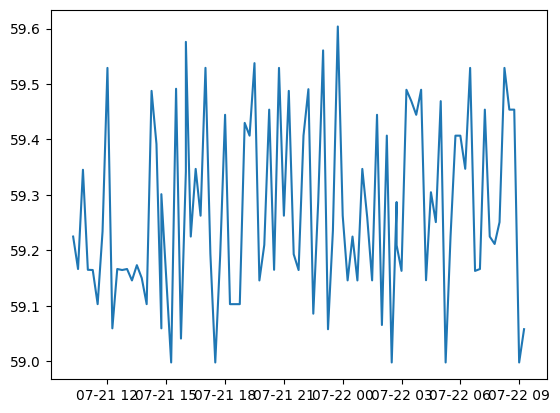

Temperature:



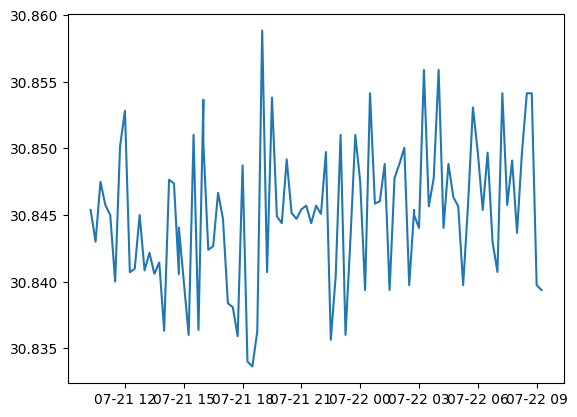

Soil Moisture:



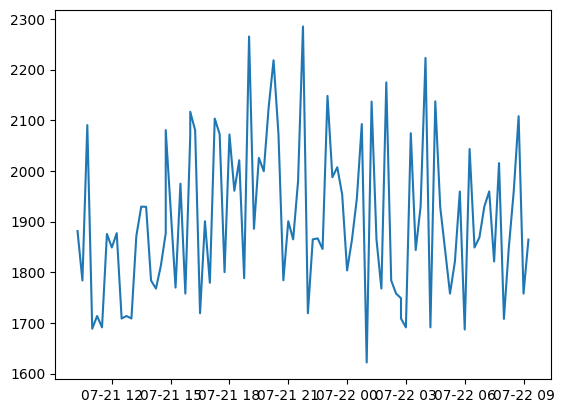

MQ135:



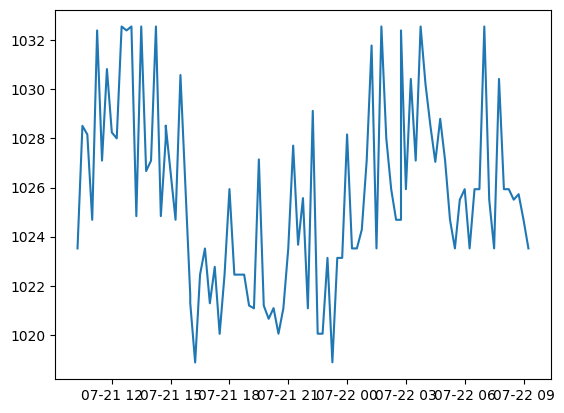

In [ ]:
# define data values
X_ax = Ds["Timestamp"]  # X-axis points
yb = model.predict(Ds[["hour", "Humidity", "Temperature", "Soil Moisture", "MQ135 Value"]])  # Y-axis points
y_htsm = {"Humidity:\n": yb[:,0], "Temperature:\n": yb[:,1], "Soil Moisture:\n": yb[:,2], "MQ135:\n":yb[:,3]}


for r in y_htsm:
  print(r)
  plt.plot(X_ax, y_htsm[r])  # Plot the chart
  plt.show()  # display

In [ ]:
pickle.dump(model, open("redderick_model.pkl", "wb")) # Model is ready to be used :D

# Thanks for checking out! 🙂
Have a nice day, Spectro.